In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools
import collections

In [2]:
class PolicyEvaluator:
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                            puddle_coef = 100.0,  lowerleft = np.array([-4, -4]).T, upperright = np.array([4, 4]).T):
        self.pose_min = np.r_[lowerleft, 0]
        #print("self.pose_min ",self.pose_min)
        self.pose_max = np.r_[upperright, math.pi * 2]
        #print("self.pose_max ",self.pose_max)
        self.widths = widths
        
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min) / self.widths).astype(int) # x,y,θの三つのインデックス計算
        
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt))) # 直積 リストの作成
        
        self.value_function, self.final_state_flags = self.init_value_function()
        
        self.policy = self.init_policy()
        
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes])) # 直進 左右回転の計３通りのnu,omega
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num) # 状態遷移確率のデータをセット 4番出力
        
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def policy_evaluation_sweep(self):
        for index in self.indexes:
            if not self.final_state_flags[index]:
                self.value_function[index] = self.action_value(tuple(self.policy[index]), index)
                      
    # 式（10.17）
    def action_value(self, action, index):
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]:
            after = tuple(self.out_correction(np.array(index).T + delta)) #　遷移先のインデックスの差分と確率を取り出す
            reward = -self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval# 報酬
            value += (self.value_function[after] + reward) * prob
            
        return value
    
    # インデックスが状態遷移で範囲をはみ出した時の処理
    def out_correction(self, index):
        index[2] = (index[2] + self.index_nums[2]) % self.index_nums[2]
        
        return index
        
    def depth_means(self, puddles, sampling_num):
        # セルの中の座標を均等にsampling_num**点サンプリング
        dx = np.linspace(0, self.widths[0], sampling_num)
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) # 深さの合計が計算されている
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths * np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T # セルの中心座標
                for p in puddles:
                    tmp[xy] += p.depth * p.inside(pose) # 深さ * 水溜りの判定(0 or 1)
                    
            tmp[xy] /= sampling_num**2 # 深さの平均
        return tmp
        
    def init_state_transition_probs(self, time_interval, sampling_num):
        dx = np.linspace(0.001, self.widths[0] * 0.999, sampling_num) # 0.001 ~ self.width[] を等間隔にsampling_num個ならヴェル
        dy = np.linspace(0.001, self.widths[1] * 0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2] * 0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt)) # 姿勢のリスト
        
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t * self.widths[2]]).T + self.pose_min # 遷移前
                    before_index = np.array([0, 0, i_t]).T
                    
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before) # 遷移後
                    after_index = np.floor((after - self.pose_min) / self.widths).astype(int)
                    
                    transitions.append(after_index - before_index) # インデックスの差分
                    
                unique, count = np.unique(transitions, axis = 0, return_counts = True)
                probs = [c / sampling_num ** 3 for c in count]
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
                    
        
    # 制御指令値を格納する三次元配列
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums, 2]) # 4次元にする
        for index in self.indexes:
            center = self.pose_min + self.widths * (np.array(index).T + 0.5) # セルの中心座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
    
    # 初期化
    def init_value_function(self):
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums)
        
        # 各離散状態が終端状態かどうか
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T) # 0 or 1
            v[index] = self.goal.value if f[index] else -100.0 # 終端状態でなければテキトーな値をいれる
            
        return v, f
    
    # ４隅全てがゴール範囲にいるかどうか
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths * index # xy平面での左下の座標
        x_max, y_max, _ = self.pose_min + self.widths * (index + 1) # 右上の座標
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _]]
        return all ([self.goal.inside(np.array(c).T) for c in corners]) # 四つの角全部において、goal.inside が全てtrueかどうか

In [3]:
puddles = [Puddle((-2,0), (0,2), 0.1), Puddle((-0.5,-2), (2.5,1), 0.1)]
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi / 18]).T, Goal(-3,-3), puddles, 0.1, 10)
counter = 0

<IPython.core.display.Javascript object>


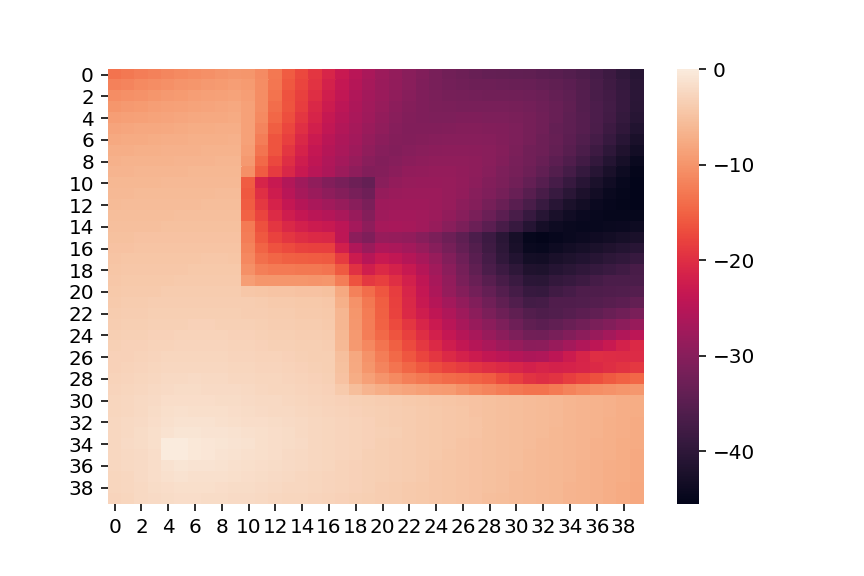

60


In [5]:
import seaborn as sns
for i in range (50):
    pe.policy_evaluation_sweep()
    counter += 1
    
v = pe.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square = False)
plt.show()
print(counter)
# 水溜りより奥は価値が小さくなっている